# Welcome to the Drone Simulation notebook!
The goal of this notebook is for you to build a simulation of the flight of a drone while it drops off life saving medical supplies! The simulation will allow us to design an autonomous system that can make the deliveries without our intervention!

Let's get started by importing some packages. Take a look at the comments if you want to see what each does.

In [ ]:
# these libraries and setting will allow us to visualize the flight trajectories of our drone
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import random # Used to generate random numbers
import numpy as np # Used for matrices and arrays

### Defining the drone
We will begin by creating a new class that represents a drone. Remember that a class is a way of grouping variables together. This class should have four variables, 2 for the position of the drone and two for its velocity. 


In [ ]:
class Drone:
   def __init__(self, x, y, vx, vy):
     self.x = x
     self.y = y
     self.vx = vx
     self.vy = vy

In lecture, we developed a model of the flight of a drone based on Newton's laws of motion. Here we will **implement** that model using python code! Write a function that takes in a drone and some applied forces `Fx`, `Fy` and updates the drones position and velocity

**Optional question:** We didn't choose to model drag from the air, but we could model this by saying that the drone has a max speed of `10`. change your update function so that the velocity of the drone is never larger than 10 in either direction. 

In [ ]:
def update(drone, Fx, Fy):
  t = 1 # We assume the update happens every 1 second

  # Define the mass of the drone (your choice! but 1 is a good option)
  m = 1

  # Update the velocity of the drone based on the applied throttle
  drone.vx = drone.vx + (Fx / m)*t
  drone.vy = drone.vy + (Fy / m)*t
  

  # Update the position of the vehicle using the current velocity
  drone.x = drone.x + drone.vx*t
  drone.y = drone.y + drone.vy*t


## Drone simulator
Now that we know how the drone will move at each timestep we can write our simulation loop. Follow the instructions in the code below to complete the loop

In [ ]:
def simulate(drone, controller = None, wind = None):
  # Start by making some empty lists that will store the drone's position over time
  xs = []
  ys = []

  # Set the initial time to be zero
  t = 0 

  # Write a loop that will run until t=100, incrementing t by 1 each time
  for t in range(0,101):
    # Add the current position of the drone to each of the lists
    xs.append(drone.x)
    ys.append(drone.y)

    # Compute the controller thrust and the wind
    Tx, Ty = (0,0) if controller is None else controller(t)
    Wx, Wy = (0,0) if wind is None else wind(t)

    # Compute the forces acting on the drone:
    Fx = Tx + Wx
    Fy = Ty + Wy

    # Use your `update` function to update the drone
    update(drone, Fx, Fy)

  return (xs, ys)

## Animation and Plotting
The code in the next block is used to plot and animate the flight of your drone. 

**Optional question:** Look through the code and see if you can figure out how it works. Try changing the color of the lines and waypoints.

In [ ]:
path = "https://www.pinclipart.com/picdir/big/520-5207275_drone-clipart.png"
image = plt.imread(path)

def make_animation(drone_path, flight_plan = None, waypoints = None):
  assert(len(x) == len(y))
  fig, ax = plt.subplots()
  drone_x, drone_y = [], []
  fp_x, fp_y = [], []
  ln1, = plt.plot([], [], 'r-')
  ln2, = plt.plot([], [], 'b-')
  if waypoints is not None:
    ln3, = plt.plot([w[0] for w in waypoints], [w[1] for w in waypoints], 'y*', markersize=10)
  im = OffsetImage(image, zoom=2/ax.figure.dpi)
  im.image.axes = ax

  def init():
      ax.set_xlim(0, 110)
      ax.set_ylim(0, 110)
      ax.set_xlabel("x-position")
      ax.set_ylabel("y-position")
      
      return ln1,

  def frame(i):
      drone_x.append(drone_path[0][i])
      drone_y.append(drone_path[1][i])
      ln1.set_data(drone_x, drone_y)

      if flight_plan is not None:
        fp_x.append(flight_plan[0][i])
        fp_y.append(flight_plan[1][i])
        ln2.set_data(fp_x, fp_y)
     
      ax.set_title("t=%d" % i)
      ab = AnnotationBbox(im, (x[i],y[i]), frameon=False, pad=0.0,)
      if len(ax.artists) > 0:
        ax.artists[0].remove()
      ax.add_artist(ab)
      return ln1,

  ani = animation.FuncAnimation(fig, frame, frames=range(0,len(x)-1,2),
                    init_func=init, blit=True)
  return ani

## Testing your simulation
Congrats on writing our simulation and update code! To make sure that it is working, lets run a simulation and then animate the results. The code below intializes a drone to the position (0,0) with a velocity of (1.5, 2.5) and lets the simulation run. The result should be that your drone flies in a straight line

In [ ]:
%%capture
drone_start = Drone(0,0,1.5,2.5)
x, y = simulate(drone_start)
anim = make_animation((x,y))
# Run the next block to see the results! (it may take a minute to run)

In [ ]:
anim

## Making our flightplan
The operations team has given us a map that shows all of the places that need medical supplies, shown as yellow stars or **waypoints** on the map below. Your job is to come up with a sequence of waypoints that we should visit. I should start and end with the location of our launching facility at `[0,0]`. You don't have to include all of the waypoints if you don't want to (we have other aircraft in the vicinity who can help out)

![image](https://drive.google.com/uc?export=view&id=1JgKU3VPz4RHZTadT_fnuEJwARpq2INE2)

Fill in your waypoint selections below:

In [ ]:
waypoints = [[0,0], [40, 40], [90,30], [0,0]]

## Desiging a Flight Plan
Now that you have done the job of high-level "planning", this function with take your selected value of waypoints and produce a trajectory that passes through them in order. No need to write any code for the flight plan function but feel free to try to figure out what it is doing!

In [ ]:
def flight_plan(waypoints):
  # Initialize the lists that will store the xy positions of the flight plan
  xs = [] 
  ys = []

  # Number of timesteps to record
  T = 100

  # Compute the distance between each waypoint
  distances = []
  for i in range(1, len(waypoints)):
    w1 = waypoints[i-1]
    w2 = waypoints[i]
    distances.append(np.sqrt((w1[0] - w2[0])**2 + (w1[1] - w2[1])**2))

  # Compute the number of samples between each waypoints
  dtot = sum(distances)
  Npts = [int(round(T*d / dtot)) for d in distances]
  Npts[-1] += T - sum(Npts) # make sure the total points is 100

  for i in range(1, len(waypoints)):
    w1 = waypoints[i-1]
    w2 = waypoints[i]
    xs.extend(np.linspace(w1[0], w2[0], Npts[i-1]))
    ys.extend(np.linspace(w1[1], w2[1], Npts[i-1]))

  return (xs, ys)

Now lets Plot our flight plan. Run the code below to see the results

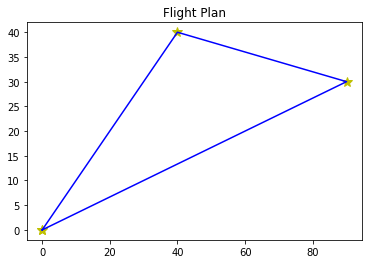

In [ ]:
fp_x, fp_y = flight_plan(waypoints)
plt.plot([w[0] for w in waypoints], [w[1] for w in waypoints], 'y*', markersize=10)
plt.plot(fp_x, fp_y, 'b-')
p = plt.title("Flight Plan")

# Designing your Flight Controller
Now we have all of the pieces together that you need to design your first autonomous system! For this first version we will design what is called an "open-loop controller", which means that it will not get feedback about where it is in the world. Instead, we will list our a series of commands to be applied at specific times to get the drone to get near all of the waypoints. 

Before you do anything else, run the code below now and see what happens!

You should see that your drone takes off in a straight line is isn't able to hit all the way points. 

Now, in the openloop controller function, add the line 
```
if t==20:
   return (-1,1)
```
and re-run your code. What happens now?

Try to come up with a sequence of commands that allows your drone to hit all (or some of its waypoints)


In [ ]:
%%capture
def openloop_controller(t):
  if t==0:
    return (1,1)
  if t>18 and t < 21:
    return (0,-1.2)
  if t>37 and t<44:
    return (-0.5, 0)
  return (0,0)

x, y = simulate(Drone(0,0,1,1), openloop_controller)
anim = make_animation((x,y), flight_plan(waypoints), waypoints)

In [ ]:
anim

## Adding disturbances. 
Now that you have created an openloop controller, let's see what happens when the drone is subjected to some disturbances. Fill in the function below to return `(Wx, Wy)` where each one is randomly sampled from the range `[-1, 1]`. If you are unsure how to do this, look into the function `random.uniform`.

In [ ]:
def windy(t):
  return (random.uniform(-.1,.1), random.uniform(-.1,.1))

Now re-run your open-loop controller and see what effect the wind has!

In [ ]:
%%capture
x, y = simulate(Drone(0,0,1,1), openloop_controller, windy)
anim = make_animation((x,y), flight_plan(waypoints), waypoints)

In [ ]:
anim

## Nice Job!

Great job building your first simulator! That was not easy! As you may have found, desiging openloop controllers is time consuming and doesn't work well when your system has disturbances. Tomorrow we will learn about closed-loop control which can fix these problems!

# Start of day 2 - Designing your closed-loop controller
Yesterday we saw how we can design an open-loop controller to make a drone fly to some waypoints. It took a lot of trial and error to find the right thrust commands and when it got windy, we found that our open-loop controller didn't work very well. Today we will use closed-loop control to automate this process for us. 

## Proportional Control
To apply proportional control we need to compute two things

1. The error in our position
2. The control "gain" that defines how much thrust we use

To get the error, we need to know where we want the drone to be so we use our flightplan that we developed yesterday. Run the following code to create the flightplan

In [ ]:
my_flight_plan = flight_plan(waypoints)
print("The flightplan has ", len(my_flight_plan[0]), " points for the x-position and ", len(my_flight_plan[1]), "points in the y position")

The flightplan has  100  points for the x-position and  100 points in the y position


The flightplan is a tuple of two arrays that contain the x-position and y-position of the drone at each point in time. To make sure you understand how the flight plan works, try to find the x and y position of the drone at t=10. The answer should be `(14.814814814814813 ,  14.814814814814813)`

In [ ]:
### Your code goes here:
xpos = my_flight_plan[0][10]
ypos = my_flight_plan[1][10]
################################
print("The (x,y) position of the drone at t=10 is: (", xpos, ", ", ypos, ")")

The (x,y) position of the drone at t=10 is: ( 14.814814814814813 ,  14.814814814814813 )


Using our knowledge of the flightplan lets simulate the proportional control.
Follow the instructions below to compute your current error and the corresponding thrust.

1. Compute the error using the expression `error = desired position - actual position`
2. Compute the thrust using the expression `thrust = Kp * error`, where `Kp` is called the proportional gain of the system

Keep in mind that we have to do this with each dimension separately

In [ ]:
def proportional_control(drone, Kp, wind = None):
  xs = []
  ys = []
  t = 0
  while t < 100:
    xs.append(drone.x)
    ys.append(drone.y)
    ####### Your code goes in this block here #########
    # compute the x and y error of your drone's position compared to the flight plan
    xperror = my_flight_plan[0][t] - drone.x
    yperror = my_flight_plan[1][t] - drone.y

    # Compute the x and y thrust based on the propotional control gain 
    Tx = Kp * xperror
    Ty = Kp * yperror

    ##########################################

    Wx, Wy = (0,0) if wind is None else wind(t)
    update(drone, Tx+Wx, Ty+Wy)
    t = t+1

  return (xs, ys)

Run your code to produce an animation of the proportional controller. Why does the drone oscillate around like that? Ask a friend or a mentor if you aren't sure!

In [ ]:
%%capture
x, y = proportional_control(Drone(0,0,0,0), 1)
anim = make_animation((x,y), my_flight_plan, waypoints)

In [ ]:
anim

How does it do in the presence of wind? Run the following code to find out!

In [ ]:
%%capture
x, y = proportional_control(Drone(0,0,0,0), 1, windy)
anim = make_animation((x,y), my_flight_plan, waypoints)

In [ ]:
anim

Not bad! Now lets try to get rid of those oscillations by including the "derivative" term into the controller

## Derivative Control

Derivative control is used to limit the amount of oscillations that the drone experiences in flight by reducing the control when the error is getting smaller. To check if the error is getting smaller we must keep track of the error in the previous timestep. To get you started we have computed the initial error and stored it in the variables `err_x_prev` and `err_y_prev`. Then on each timestep we store the last error values in them. To add your derivative control, do the following steps

1. Compute the difference between the current error and the error from the last timesteps
2. Multiply that difference by the derivative gain `Kd` and add it to the thrust

Again remember that you need to do this for both dimensions

In [ ]:
def proportional_derivative_control(drone, Kp, Kd, wind = None):
  xs = []
  ys = []
  t = 0

  # Start by computing the initial error:
  err_x_prev = my_flight_plan[0][0] - drone.x
  err_y_prev = my_flight_plan[1][0] - drone.y

  while t < 100:
    xs.append(drone.x)
    ys.append(drone.y)

    # Here is the code from the proportional controller:
    err_x = my_flight_plan[0][t] - drone.x
    err_y = my_flight_plan[1][t] - drone.y
    Tx = Kp * err_x
    Ty = Kp * err_y

    ####### Your code goes in this block here #########
    # Compute the difference between the current error and the previous error
    diff_error_x = err_x - err_x_prev
    diff_error_y = err_y - err_y_prev

    # Add that difference with the appropriate control gain
    Tx += (diff_error_x * Kd)
    Ty += (diff_error_y * Kd)


    ##########################################
    
    err_x_prev = err_x
    err_y_prev = err_y

    Wx, Wy = (0,0) if wind is None else wind(t)
    update(drone, Tx+Wx, Ty+Wy)
    t = t+1

  return (xs, ys)

Now let's see how the derivative control helps our drone reach the waypoints! If everything is working properly then the drone should track the flight plan really closely, even in windy conditions!

In [ ]:
%%capture
x, y = proportional_derivative_control(Drone(0,0,0,0), 1, 0.5, windy)
anim = make_animation((x,y), my_flight_plan, waypoints)

In [ ]:
anim

Good job!!
Now lets see what happens when the wind is no longer random, and instead blows really hard in one direction. Run the cells below to define a function the produces a strong wind in the y direction and then re-run the simulator. What happens?

In [ ]:
def strong_wind(t):
  return (0, 3)

In [ ]:
%%capture
x, y = proportional_derivative_control(Drone(0,0,0,0), 1, 0.5, wind=strong_wind)
anim = make_animation((x,y), my_flight_plan, waypoints)

#Kp. Kd

In [ ]:
anim

Oh no! It looks like our controller cannot compensate for a strong headwind. To fix this problem we can add integral control which keeps track of how much error has accumlated over time in order to fix problems like this.

## Integral Control
When there are really strong disturbances, the proportional control gain may not be enough for correct for them (as we see in the example above). Instead we can include an "Integral" term that keeps track of accumulated error and applies more control when the accumulated error is large!

We have to keep track of the accumulated error so we have defined some variables (`err_x_total` and `err_y_total`) to store that information. Then to include your integral term take the following steps:

1. Add the current error to the accumulated error counter
2. Multiple the accumulated error by the integral control gain `Ki` and add it to the corresponding thrust

Keep in mind that you have to do this in both dimensions!

In [ ]:
def proportional_integral_derivative_control(drone, Kp, Kd, Ki, wind = None):
  xs = []
  ys = []
  t = 0
  # Start by computing the initial error:
  err_x_prev = my_flight_plan[0][0] - drone.x
  err_y_prev = my_flight_plan[1][0] - drone.y

  # Set the accumulated error to zero:
  err_x_total = 0
  err_y_total = 0
  while t < 100:
    xs.append(drone.x)
    ys.append(drone.y)
    # Here is the code from the proportional controller:
    err_x = my_flight_plan[0][t] - drone.x
    err_y = my_flight_plan[1][t] - drone.y

    # Here is the code from the derivative controller
    derr_x = err_x - err_x_prev
    derr_y = err_y - err_y_prev

    # Add that difference with the appropriate control gain
    Tx = Kp * err_x + Kd * derr_x
    Ty = Kp * err_y + Kd * derr_y

    ####### Your code goes in this block here #########
    # Accumulate the error 
    err_x_total += err_x
    err_y_total += err_y
    # Add the integral term

    Tx += (err_x_total * Ki)
    Ty += (err_y_total * Ki)

    ##########################################

    err_x_prev = err_x
    err_y_prev = err_y

    Wx, Wy = (0,0) if wind is None else wind(t)
    update(drone, Tx+Wx, Ty+Wy)
    t = t+1

  return (xs, ys)

Now lets run our final controller in the presence of strong winds. Are we able to cope with them?

In [ ]:
%%capture
x, y = proportional_integral_derivative_control(Drone(0,0,0,0), 1, 0.5, 0.05, wind=strong_wind) # KI 0.05
anim = make_animation((x,y), my_flight_plan, waypoints) #KP is 0.5

In [ ]:
anim

Nice job! With PID control you can solve all sorts of real-world problems like flying planes and launching rockets into space! If you have time left in the session go back and play around with the different values of the gains. Can you break the controller? Choosing these gains is often the hardest part when design